# Breast Cancer Diagnosis

## Path Variables and constants

In [1]:
# Constants
TEST_SIZE = 0.10
VAL_SIZE = 0.10

# Path Variables
DATASET_FOLDER = 'datasets/'
MODELS_FOLDER = 'models/'

## Import packages

In [2]:
import random
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

%matplotlib inline
warnings.filterwarnings("ignore")

## Dataset loading and preprocessing
1. Load dataset
2. Study dataset
3. Visualization (if needed)
4. Preprocessing
5. Normalization
6. Validation Train Test Split

In [3]:
def fetch_data(path):
    dataset_path = DATASET_FOLDER + path
    return pd.read_csv(dataset_path)

dataset = fetch_data('breast_cancer.csv')
print('Dataset shape - ', dataset.shape)
dataset.head()

Dataset shape -  (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Dataset Attributes - 
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry 
* fractal dimension ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

- class:
        * WDBC-Malignant
        * WDBC-Benign

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
dataset.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
dataset.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

The 'id' column is a personal identifier, which must be removed, further, the diagnosis is categorical column which must be converted to 0 or 1. 

In [7]:
dataset.drop('id', axis=1, inplace=True)
label = 'diagnosis'

In [8]:
dataset[label] = (dataset[label] == 'M').astype(int)

In [9]:
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
dataset[label].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

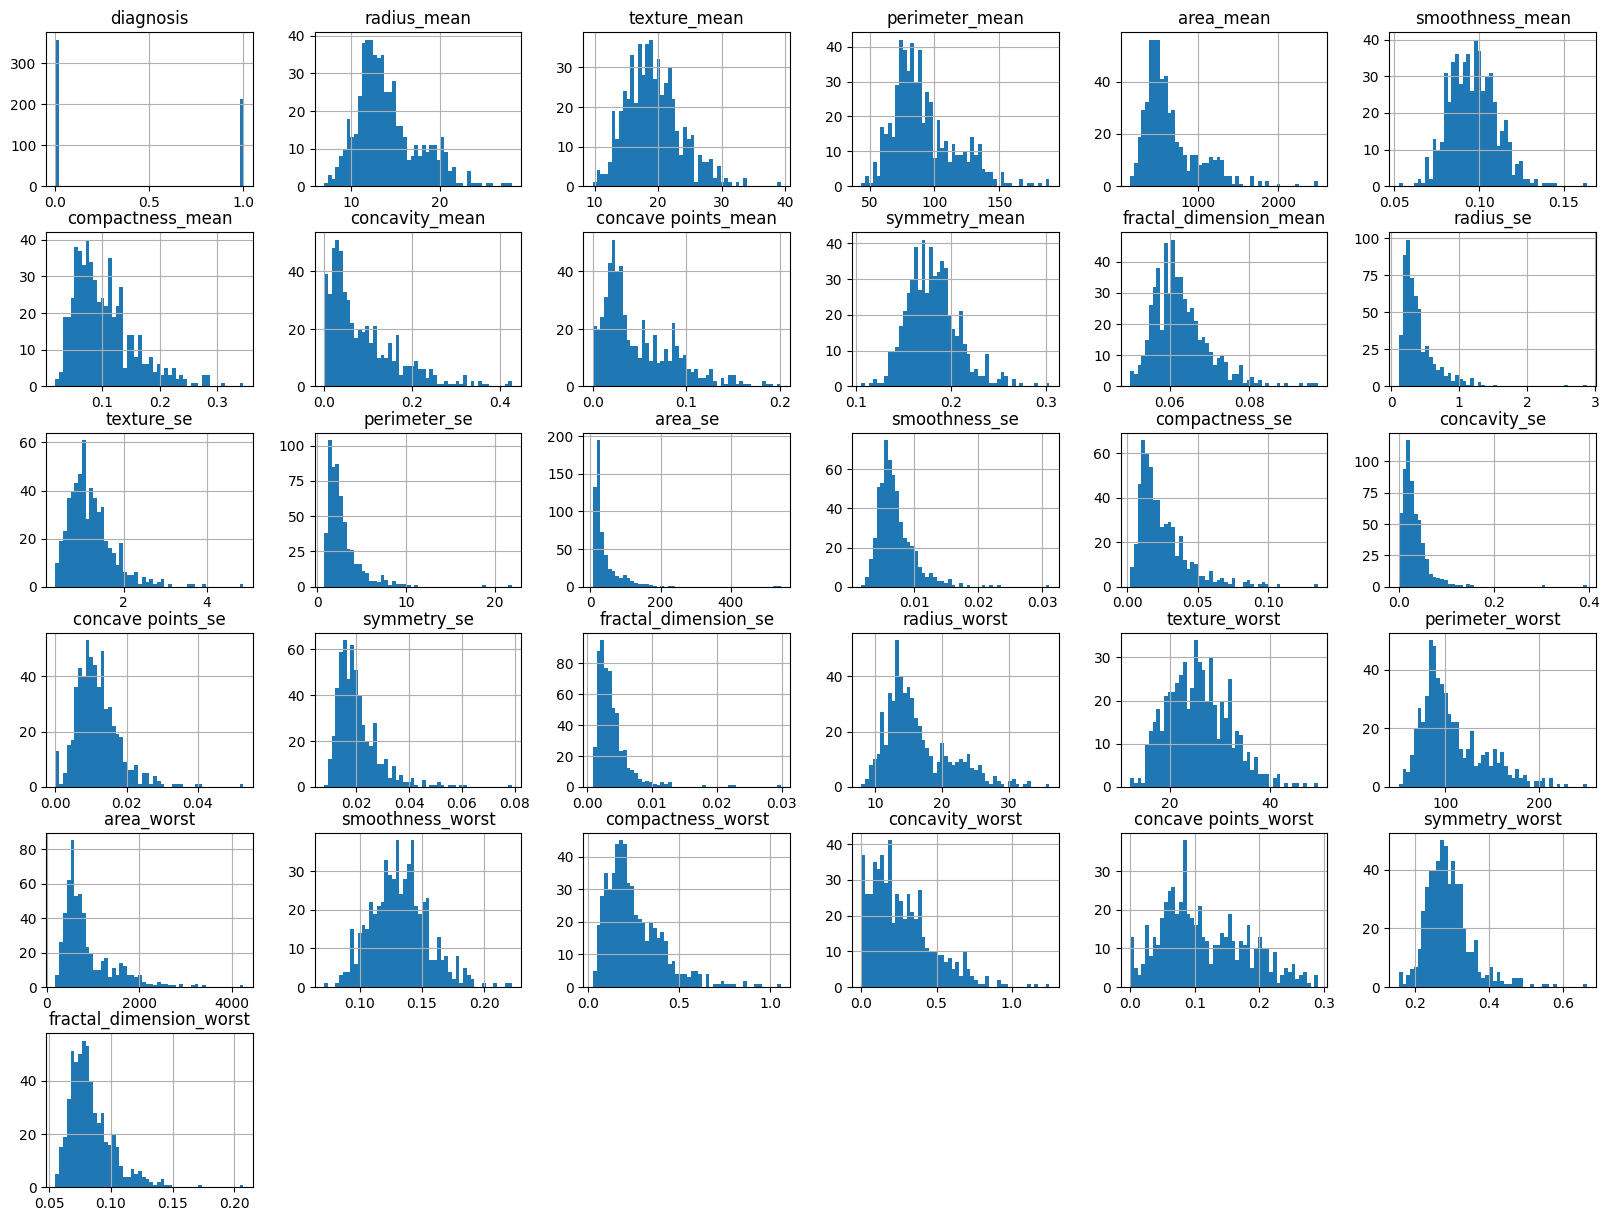

In [11]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# Correlation Study

corr_matrix = dataset.corr()
plt.figure(figsize=(20,20))
colors = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
sns.heatmap(corr_matrix, cmap=colors,annot=True)
plt.show()

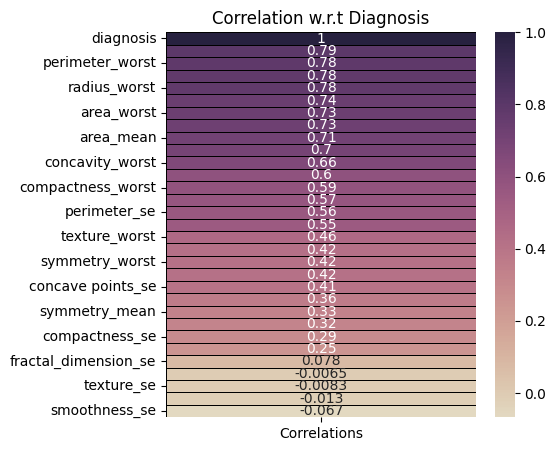

In [13]:
# Checking only for Diagnosis with all other attributes
corr_matrix = dataset.corrwith(dataset[label]).sort_values(ascending = False).to_frame()
corr_matrix.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr_matrix,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Diagnosis');

# Not all attributes are important here, we will be removing less important attributes.
# Select highly correlated features (thresold = 0.2)
important_features = corr_matrix[abs(corr_matrix)>0.2]

# Collect the names of the features
attributes = list(important_features.index)

# Drop the target variable from the results
attributes.remove(label)

In [14]:
X = dataset[attributes]
y = dataset[label]

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size = TEST_SIZE, 
                                                            stratify = dataset[label], 
                                                            random_state = 42)

# If we have larger dataset, we may also use val sets, but for now will stick to only train and test.

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size = VAL_SIZE, 
                                                            stratify = y_train_val,
                                                            random_state = 42)

In [16]:
print('Train split size: X - {}, y - {}'.format(X_train.shape, y_train.shape))
print('Validation split size: X - {}, y - {}'.format(X_val.shape, y_val.shape))
print('Test split size: X - {}, y - {}'.format(X_test.shape, y_test.shape))

Train split size: X - (460, 30), y - (460,)
Validation split size: X - (52, 30), y - (52,)
Test split size: X - (57, 30), y - (57,)


In [17]:
X_train.head(10)

,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst,...,smoothness_mean,symmetry_mean,fractal_dimension_worst,compactness_se,concavity_se,fractal_dimension_se,symmetry_se,texture_se,fractal_dimension_mean,smoothness_se
309,0.035320,93.96,0.008829,14.730,82.71,672.4,13.050,530.6,0.004559,0.018240,...,0.08352,0.1453,0.06580,0.004711,0.002831,0.002273,0.01422,0.8285,0.05518,0.004148
238,0.082190,102.50,0.044080,15.750,92.55,764.0,14.220,623.9,0.110300,0.306400,...,0.08223,0.1342,0.07796,0.028450,0.038500,0.003589,0.01185,2.3240,0.06129,0.006307
480,0.056900,88.83,0.015270,13.340,78.29,547.4,12.160,455.3,0.029160,0.162000,...,0.09087,0.1464,0.07729,0.016660,0.013970,0.001858,0.01454,1.1900,0.06284,0.004911
247,0.156100,105.00,0.039800,14.390,84.95,639.1,12.890,512.2,0.137400,0.772700,...,0.08760,0.1596,0.11780,0.055920,0.081580,0.007555,0.01266,0.4402,0.06409,0.005501
389,0.182500,142.00,0.102100,20.820,128.90,1313.0,19.550,1174.0,0.185600,0.382900,...,0.10100,0.1989,0.07602,0.040970,0.074690,0.006240,0.02768,2.8360,0.05884,0.011240
178,0.009259,88.18,0.001852,14.000,82.01,608.8,13.010,526.4,0.001595,0.007977,...,0.06251,0.1395,0.05843,0.002252,0.001595,0.000968,0.01613,1.1420,0.05234,0.003418
42,0.249300,177.40,0.099610,24.090,128.30,1651.0,19.070,1104.0,0.210700,0.724200,...,0.09081,0.2310,0.10380,0.100600,0.097230,0.007646,0.05333,1.6660,0.06343,0.006548
246,0.049700,88.28,0.011050,13.940,84.13,602.0,13.200,541.6,0.043360,0.229800,...,0.07215,0.1487,0.07198,0.015690,0.030790,0.002250,0.01962,1.6010,0.05635,0.006261
171,0.116000,116.60,0.034380,17.980,85.84,993.6,13.430,565.4,0.058580,0.264400,...,0.09048,0.1598,0.07371,0.010630,0.021510,0.001868,0.01520,1.1470,0.05671,0.006003
314,0.000000,56.65,0.000000,8.952,54.09,240.1,8.597,221.2,0.000000,0.000000,...,0.10740,0.2163,0.08116,0.014030,0.000000,0.006820,0.06146,2.7770,0.07359,0.020750


In [18]:
# We will create a custom pipeline that will handle the null values and normalization

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, attributes),
    ])

X_train_transformed = full_pipeline.fit_transform(X_train)

In [19]:
X_train_transformed[1,:]

array([-0.49610881, -0.14840857, -0.11155926, -0.11293385,  0.02577728,
       -0.21002317,  0.02649471, -0.08772517,  0.29095798,  0.16152078,
        0.02148772, -0.06491964, -0.25830504, -0.40322797, -0.25588683,
        2.40081516, -1.02624699, -1.63140525,  1.96625358, -0.26074864,
       -0.9693613 , -1.70861115, -0.32249673,  0.21142543,  0.22543205,
       -0.05062312, -1.02334774,  1.98754093, -0.19513417, -0.1964826 ])

## Training Various Models

1. Cross Validation on various models
2. Choose best model

* We wil try fitting the data to 3 models - 
1. Logistic Regression Model
2. SVM Classifier
3. Random Forest Classifier

* For each of the model, we will use the cross val score to fit and evaluate over 5 folds of train data.

In [20]:
def model(classifier, X_train_transformed, y_train):
    
    classifier.fit(X_train_transformed,y_train)
    prediction = classifier.predict(X_train_transformed)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_train, prediction)))
    print("Recall : ",'{0:.2%}'.format(recall_score(y_train, prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier, X_train_transformed, y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_train, prediction)))
    RocCurveDisplay.from_estimator(classifier, X_train_transformed, y_train)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier, X_val, y_val):
    
    # Confusion Matrix
    cm = confusion_matrix(y_val,classifier.predict(full_pipeline.transform(X_val)))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    # Classification Report
    print(classification_report(y_val, classifier.predict(full_pipeline.transform(X_val))))

Accuracy :  98.70%
Recall :  97.67%
Cross Validation Score :  99.10%
ROC_AUC Score :  98.49%


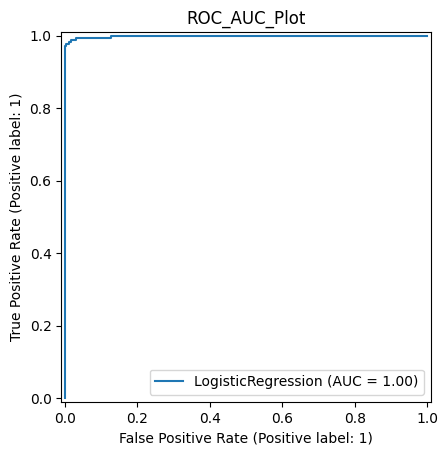

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.95      0.97        19

    accuracy                           0.98        52
   macro avg       0.99      0.97      0.98        52
weighted avg       0.98      0.98      0.98        52



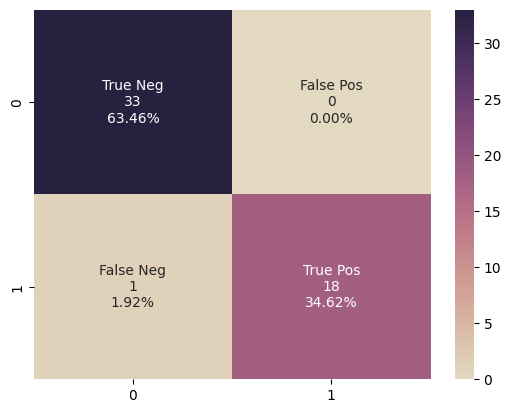

In [21]:
# Logistic Regression Classifier
log_clf = LogisticRegression(solver='lbfgs', C=10, penalty='l2', max_iter=10000, random_state = 42)
model(log_clf, X_train_transformed, y_train)
model_evaluation(log_clf, X_val, y_val)

Accuracy :  98.48%
Recall :  95.93%
Cross Validation Score :  99.47%
ROC_AUC Score :  97.97%


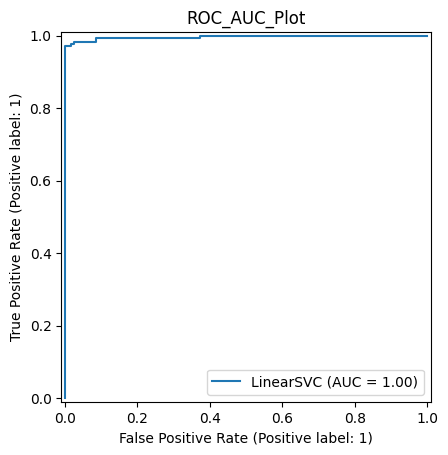

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.95      0.97        19

    accuracy                           0.98        52
   macro avg       0.99      0.97      0.98        52
weighted avg       0.98      0.98      0.98        52



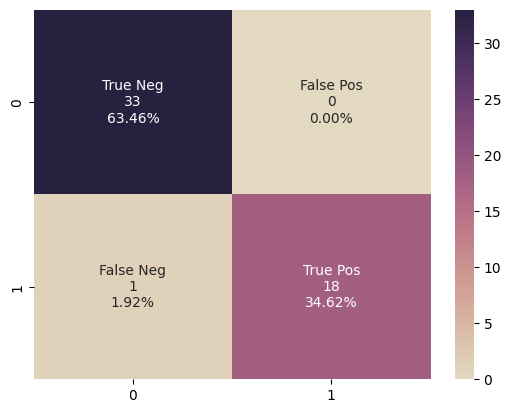

In [22]:
lin_clf = LinearSVC(loss="hinge", C=0.5, random_state=42)
model(lin_clf, X_train_transformed, y_train)
model_evaluation(lin_clf, X_val, y_val)

# svm_clf = SVC(kernel = "linear")
# model(lin_clf, X_train_transformed, y_train)
# model_evaluation(lin_clf, X_val, y_val)

Accuracy :  99.35%
Recall :  98.26%
Cross Validation Score :  98.93%
ROC_AUC Score :  99.13%


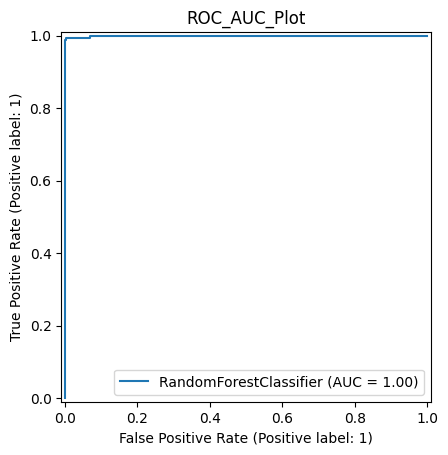

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.89      0.94        19

    accuracy                           0.96        52
   macro avg       0.97      0.95      0.96        52
weighted avg       0.96      0.96      0.96        52



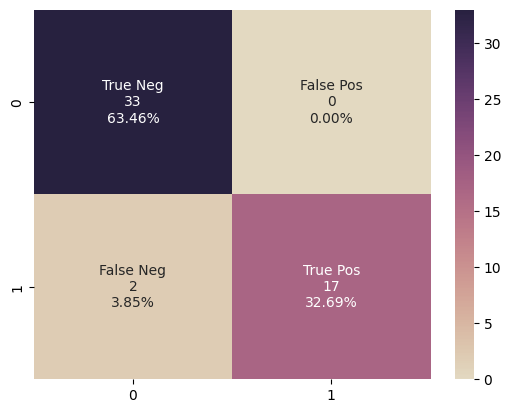

In [23]:
forest_clf = RandomForestClassifier(max_depth=5, n_estimators=500, criterion='gini', random_state = 42)
model(forest_clf, X_train_transformed, y_train)
model_evaluation(forest_clf, X_val, y_val)

Accuracy :  96.30%
Recall :  90.70%
Cross Validation Score :  98.96%
ROC_AUC Score :  95.18%


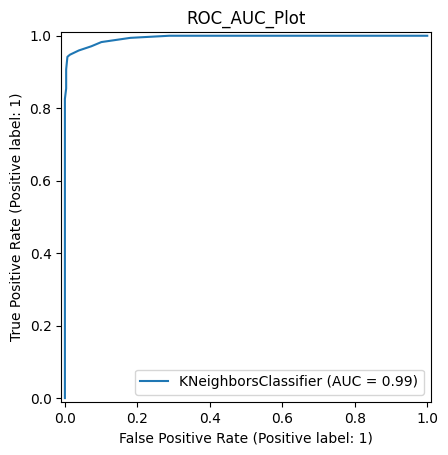

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.95      0.97        19

    accuracy                           0.98        52
   macro avg       0.99      0.97      0.98        52
weighted avg       0.98      0.98      0.98        52



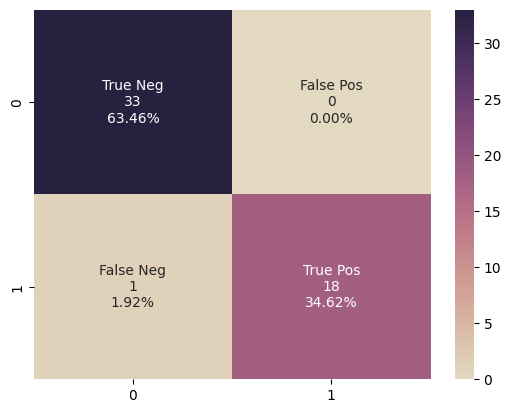

In [24]:
knn_clf = KNeighborsClassifier(n_neighbors=15, p=2, metric='euclidean')
model(knn_clf, X_train_transformed, y_train)
model_evaluation(knn_clf, X_val, y_val)

As we can see all the scores are comparable, we can select any model. We will continue with the Logistic Regression Classifier.

## Evaluation on best model
1. Train again on best model and get evaluation
2. Test set evaluation
3. Present metrics

In [25]:
param_grid = {'C': [0.05, 0.1, 0.5, 1, 5, 10], 'penalty':['l1', 'l2'], 'solver':['lbfgs', 'linear']}

log_clf = LogisticRegression(max_iter=10000, random_state = 42)
grid_search = GridSearchCV(log_clf, param_grid, cv=10,
                           return_train_score=True)
grid_search.fit(X_train_transformed, y_train)


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.05, 0.1, 0.5, 1, 5, 10],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'linear']},
             return_train_score=True)

In [26]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9673913043478259
{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [27]:
log_clf = grid_search.best_estimator_

In [28]:
X_test_transformed = full_pipeline.transform(X_test)
y_pred = log_clf.predict(X_test_transformed)

In [29]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        21

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



From the above results we can see that the model has a good precision and a reasonable recall value. In medical use cases (where we are trying to predict if a person has a disease or not), it is better to have a good recall as we want the model to identify all the patients who have the disease. 

The recall of the model can be improved by having more data with balanced labels. Our dataset has imbalanced labels (0 : 500, 1: 268) due to which the results are suboptimal.

## Full data training
1. Train on full data
2. Pickle trained model


In [30]:
X, y = dataset[attributes], dataset[label]

In [31]:
X_transformed = full_pipeline.fit_transform(X)

In [32]:
log_clf = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'lbfgs', max_iter=10000, random_state = 42)

In [33]:
log_clf.fit(X_transformed, y)

LogisticRegression(C=0.1, max_iter=10000, random_state=42)

In [34]:

random_index = random.randint(0, len(X_transformed))
instance = X_transformed[random_index]
label = y[random_index]

print('Index - ', random_index,'\n')
print('Instance - ', instance,'\n')
print('Label - ', label)
print('Breast Cancer' if label==1 else 'No Breast Cancer')

Index -  86 

Instance -  [ 0.12019536  0.03391974  0.01188726 -0.01225717  0.09395347 -0.12601268
  0.10017415 -0.0190245   0.39674568  0.30085998 -0.09231236 -0.36046885
  0.05496085  0.215309   -0.03227825  0.58180452 -0.0775279   0.1929111
  0.50505536  0.94306476 -0.13665766  0.96159048 -0.85815922  0.24322352
  0.72336302 -0.20648887  0.44044742  1.82005286 -0.91259818  0.77603849] 

Label -  1
Breast Cancer


In [35]:
prediction = log_clf.predict([instance])
print('Breast Cancer Detected' if prediction[0]==1 else 'Breast Cancer NOT Detected')

Breast Cancer Detected


In [36]:
# Saving the model
dump = {
    'model' : log_clf,
    'report' : report
}

filename = 'breast_cancer_log_clf.pkl'

pickle.dump(dump, open(MODELS_FOLDER+filename, 'wb'))